In [36]:
import pandas as pd 
import re
from datetime import datetime
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.express as px


In [37]:
#function to parse the date range for weekly column names
def parse_date_range(date_range_str):
    """
    Convert date range strings like "Jan 1-7, 2023" or "Jan 29 - Feb 4, 2023" to datetime objects.
    """
    # Extract the month and year
    match = re.match(r'([a-zA-Z]+) (\d+)-(\d+), (\d+)', date_range_str)
    if match:
        month = match.group(1)
        start_day = match.group(2)
        end_day = match.group(3)
        year = match.group(4)
        start_date_str = f"{month} {start_day}, {year}"
        start_date = datetime.strptime(start_date_str, '%b %d, %Y')
        return start_date
    else:
        # Handle cases like "Jan 29 - Feb 4, 2023"
        match = re.match(r'([a-zA-Z]+) (\d+) - ([a-zA-Z]+) (\d+), (\d+)', date_range_str)
        if match:
            start_month = match.group(1)
            start_day = match.group(2)
            end_month = match.group(3)
            end_day = match.group(4)
            year = match.group(5)
            start_date_str = f"{start_month} {start_day}, {year}"
            start_date = datetime.strptime(start_date_str, '%b %d, %Y')
            return start_date

#### Inputs

In [38]:
mydatesby = 'daily'  # 'daily' or 'weekly'
# mydatesby = 'weekly'

start_date = '2023-01-01'
end_date = '2024-06-30'
myrow = 'Net Income'
myrow = 'Accounts Payable'
myrow = 'Inventory'
myrow = 'SBA Loan'
# myrow = 'WEHO Club CC 2143'
# myrow = 'Ramp Card'
# myrow = 'Accounts Payable'
# myrow = 'Furniture - NYC:Accumulated Depreciation - NYC Furniture'

In [39]:
if mydatesby == 'daily':
    df = pd.read_excel('rp_daily_JAN23_MAY24_pasteValues.xlsx', skiprows=4)
elif mydatesby == 'weekly':
    df = pd.read_excel('rp_week_JAN23_MAY24_pasteValues.xlsx', skiprows=4)

df = df.rename(columns={df.columns[0]: 'name'})

df = df[[col for col in df.columns if 'Total' not in col]]

# Strip whitespace from excel file columns
df[df.columns[0]] = df[df.columns[0]].str.strip()

# Melt the DataFrame to have 'dates' and 'values' columns, keeping the first column intact
melted_df = pd.melt(df, id_vars=[df.columns[0]], var_name='dates', value_name='values')

# Convert 'values' column to numeric, forcing errors to NaN
melted_df['values'] = pd.to_numeric(melted_df['values'], errors='coerce')

# Convert the 'Dates' column to datetime
if mydatesby == 'weekly':
    melted_df['dates'] = melted_df['dates'].apply(parse_date_range)
elif mydatesby == 'daily':
    melted_df['dates'] = pd.to_datetime(melted_df['dates'])

melted_df['dates'] = melted_df['dates'].dt.strftime('%Y-%m-%d')

# melted_df = melted_df.dropna(subset=[melted_df.columns[0]])
melted_df = melted_df.dropna(subset=[melted_df.columns[1]])
melted_df = melted_df.dropna(subset=[melted_df.columns[2]])


melted_df['values'] = melted_df.apply(lambda row: row['values'] if pd.notna(row[melted_df.columns[0]]) else 0, axis=1)

print(melted_df)

                                                    name       dates    values
1                                             Net Income  2023-01-01 -54878.03
9                                       Prepaid Expenses  2023-01-01  45000.00
12          Accumulated Depreciation - Machinery & Equip  2023-01-01    506.81
14     Equipment - NYC:Accumulated Depreciation - NYC...  2023-01-01   3119.92
15     Fixed Asset Computers - Corporate:Accumulated ...  2023-01-01    192.19
...                                                  ...         ...       ...
35126          Net cash provided by operating activities  2024-05-31  29734.69
35128                                      Goldman - HYS  2024-05-31 -15476.79
35142          Net cash provided by investing activities  2024-05-31 -15476.79
35150          Net cash provided by financing activities  2024-05-31      0.00
35151                       Net cash increase for period  2024-05-31  14257.90

[5637 rows x 3 columns]


### Plot Specific Rows with Prophet

In [40]:
def prophet_plot(df, row_name, start_d, end_d, n_weeks = 13):
    df = df[(df['dates'] >= start_d) & (df['dates'] <= end_d)]

    df_piv = df.pivot(index='name', columns='dates', values='values')

    #filter by row
    selected_row = df_piv.loc[row_name,:]

    new_df = pd.DataFrame({
        'ds': df_piv.columns,
        'y': selected_row.values,
        })
    
    # m = Prophet(changepoint_prior_scale=0.95).fit(new_df)
    # future = m.make_future_dataframe(periods= n_weeks*7)
    # forecast = m.predict(future)

    m = Prophet(weekly_seasonality=False)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(new_df)
    future = m.make_future_dataframe(periods= n_weeks*7)
    forecast = m.predict(future)
    fig = m.plot_components(forecast)
    return m, forecast 

11:17:24 - cmdstanpy - INFO - Chain [1] start processing
11:17:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\beets\anaconda3\envs\kordis_py\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\beets\anaconda3\envs\kordis_py\Lib\site-packages\prophet\plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\beets\anaconda3\envs\kordis_py\Lib\site-packages\prophet\plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects ins

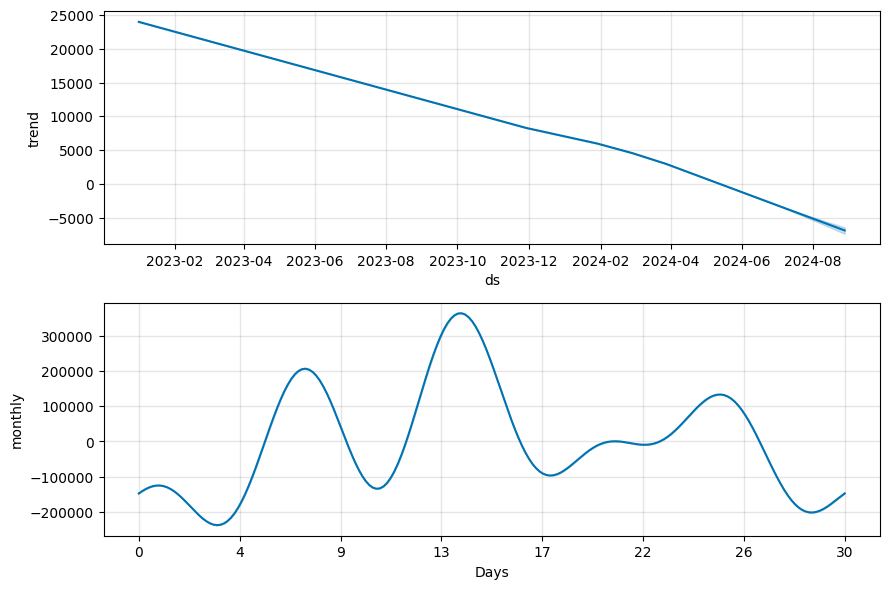

In [41]:
m, forecast = prophet_plot(melted_df, myrow, start_date, end_date)
plot_plotly(m, forecast) 

### Aggregate predictions by Week/Month

In [42]:
data = forecast[['ds','yhat']]
data.head()

# Set the ds column as the index
data.set_index('ds', inplace=True)

# Aggregate by week
df_weekly = data.resample('W').sum()
df_weekly['ds'] = df_weekly.index

# Aggregate by month
df_monthly = data.resample('ME').sum()
df_monthly['ds'] = df_monthly.index

# Display weekly and monthly tables
df_weekly_table = df_weekly.reset_index(drop=True)
df_monthly_table = df_monthly.reset_index(drop=True)

# Display tables
import IPython.display as display

display.display(df_weekly_table)
display.display(df_monthly_table)


# Plot weekly aggregation
fig_weekly = px.line(df_weekly, x='ds', y='yhat', title='Weekly Aggregation', labels={'ds': 'Date', 'yhat': 'Aggregated yhat'})
fig_weekly.show()

# Plot monthly aggregation
fig_monthly = px.line(df_monthly, x='ds', y='yhat', title='Monthly Aggregation', labels={'ds': 'Date', 'yhat': 'Aggregated yhat'})
fig_monthly.show()

,yhat,ds
0,1.500000e+05,2023-01-01
1,0.000000e+00,2023-01-08
2,0.000000e+00,2023-01-15
3,0.000000e+00,2023-01-22
4,0.000000e+00,2023-01-29
...,...,...
83,2.657404e+05,2024-08-04
84,-1.273853e+06,2024-08-11
85,3.974582e+04,2024-08-18
86,9.061847e+05,2024-08-25


,yhat,ds
0,150000.008943,2023-01-31
1,0.000000,2023-02-28
2,0.000000,2023-03-31
3,0.000000,2023-04-30
4,0.000000,2023-05-31
5,0.000000,2023-06-30
6,0.000000,2023-07-31
7,0.000000,2023-08-31
8,0.000000,2023-09-30
9,0.000000,2023-10-31
